## 1. 가상화면 세팅 

In [1]:
from webdriver_manager.chrome import ChromeDriverManager 
from selenium.webdriver.chrome.service import Service 
from selenium import webdriver

from urllib.request import urlopen
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import time
import re

In [2]:
service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)



====== WebDriver manager ======
Current google-chrome version is 99.0.4844
Get LATEST chromedriver version for 99.0.4844 google-chrome
Driver [C:\Users\KYM\.wdm\drivers\chromedriver\win32\99.0.4844.51\chromedriver.exe] found in cache


## 2. 스크래핑

In [5]:
# 각 구별 url을 불러오기 위한 키값 
gu_dict = {  '강남구':160,'강동구':162,'강북구':149, '강서구':156, '관악구':180,
            '광진구':205, '구로구':157, '금천구':189, '노원구':151, '도봉구':207,
            '동대문구':150, '동작구':159, '마포구':203, '서대문구':155, '서초구':179,
            '성동구':152, '성북구':148, '송파구':161, '양천구':202, '영등포구':158,
            '용산구':154, '은평구':141, '종로구':153, '중구':204, '중랑구':206
           }

# 데이터 프레임 생성
df = pd.DataFrame({'월':[], '조회수':[]})

# 리스트 생성 
days = []
counts = []
include1= []
include2= []


# 정규표현식 작성
date_match1 = re.compile("^(202)[0-1]\.\d{2}") #2020-2021 검사 
date_match2 = re.compile("^(2019)\.\d[2]") #2019 검사

page = 1 


# 각 구를 대상으로 반복 
for key in gu_dict:

    # 페이지를 넘겨가며 스크래핑 반복
    while True:
        url = 'https://cafe.naver.com/rainup?iframe_url=/ArticleList.nhn%3Fsearch.clubid=10955043%26search.menuid='+str(gu_dict[key])+'%26search.totalCount=301%26search.cafeId=10955043%26search.page='+str(page)
        driver.get(url)
        
        # 네이버 카페 본문 접근
        driver.switch_to.frame('cafe_main')
        
        # 페이지 +1
        page += 1   


        try:
            # 페이지 parsing & 조회수, 날짜 데이터 불러오기 
            web_page = BeautifulSoup(driver.page_source, 'html.parser')
            dates = web_page.find_all('td',{'class':'td_date'})
            views = web_page.find_all('td',{'class':'td_view'})


            # 날짜 텍스트 , 조회수 텍스트 리스트에 담기
            for date, count in zip(dates,views):
                days.append(date.get_text())
                counts.append(count.get_text())

            # 정규표현식 검사 (페이지를 넘기기 위한 )
            for day in days:
                if date_match1.search(day): # 2020.01. ~ 2021.12.
                    include1.append(day)
            
            for day in days:
                if date_match2.search(day): # 2019.01
                    include2.append(day)
            
            
            # 2019년도 데이터 15개 이상 -> 반복문 종료
            if len(include2) >= 15:
                break;
            # 2020-2021데이터가 없으면 -> 현재 loop종료 
            elif len(include1) == 0:
                continue;


             # 날짜 '월'까지 쪼개기 
            d_len=0
            for d in days:
                days[d_len] = days[d_len][:7]
                d_len+=1

            # 데이터프레임에 내용 추가
            df = pd.DataFrame({'월':days,
                           '조회수':counts,
                          })

             # 데이터 타입 object에서 int로 변경 
            df['조회수'] = df['조회수'].str.replace(pat=r'[^0-9]', repl=r'', regex=True).astype(int)


             # 데이터 프레임 필터링 
            df_v2 = df[ (df['월'] >= '2020.01') & (df['월'] < '2022.01')]


            
            df_v2['게시물 수'] =1 # 데이터 프레임 열 추가 
            df_v2 = df_v2.set_index('월') # index생성 

            pivot_df1 = pd.pivot_table(df_v2, index='월', values='조회수', aggfunc=np.sum) #피벗테이블
            pivot_df2 = pd.pivot_table(df_v2, index='월', values='게시물 수', aggfunc=np.sum) #피벗테이블 

            final = pd.merge(pivot_df1, pivot_df2, how = 'outer', on='월') #데이터프라임 합병

            final.to_excel(str(key)+'.xlsx', encoding='utf-8') # 엑셀파일로 저장

        except:
            pass        

        time.sleep(1)

# 가상환경 종료 
driver.close()
driver.quit()


## 3.스크래핑 데이터 전처리 

- 구별 조회수 데이터 
- 구별 게시물수 데이터
- 구별 조회수 증감율 데이터

In [ ]:
# '강남구' 엑셀 파일 불러오기 
df = pd.read_excel('강남구.xlsx')

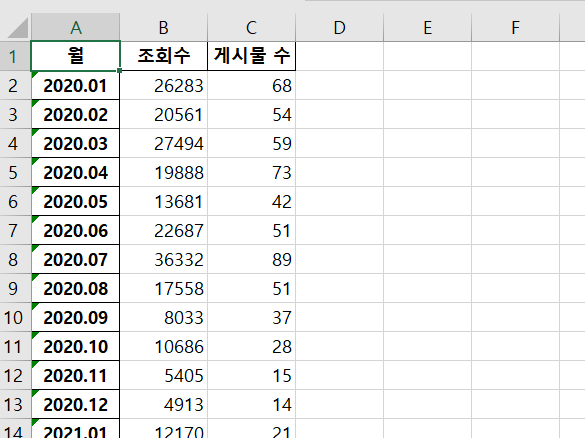

In [ ]:
# 데이터 나누기  
df_gu = df.iloc[:,0:2]  # 조회수 열
df_view = df.iloc[:,2:3] # 게시물수 열 
df_gu = df_gu.set_index('월')
df_gu.rename(columns={'조회수':'강남구'}, inplace=True) # 조회수 -> 강남구
df_view.rename(columns={'게시물 수':'강남구게시글'},inplace=True) # 게시물수 -> 강남구게시글

#df_view
#df_gu

# 불러 올 엑셀파일 이름 
gu_list = [ '강동구','강북구', '강서구', '관악구','광진구', '구로구', 
           '금천구', '노원구', '도봉구', '동대문구', '동작구', 
           '마포구', '서대문구', '서초구', '성동구', '성북구', 
           '송파구', '양천구', '영등포구', '용산구', '은평구', 
           '종로구', '중구', '중랑구' ] #강남구 


# '강남구' df에 구별 조회수 df join
for data in gu_list:
    df = pd.read_excel(data+'.xlsx')
    df2 = df.iloc[:,0:2]
    df2.rename(columns={'게시물': data }, inplace=True)
    df2 = df2.set_index('월')
    df_gu = df_gu.join(df2)
    
# '강남구게시글' df에 구별 게시글수 df join
for data in gu_list:
    df = pd.read_excel(data+'.xlsx')
    df2 = df.iloc[:,2:3]
    df2.rename(columns={ '게시물 수': data+'게시글' }, inplace=True)
    df2 = df2.set_index(index)
    df_view = df_view.join(df2)
    



# 월별 > 연도별 
df_gu.rename(index = {2020.01 : '2020년도', \
                    2020.02 : '2020년도', \
                    2020.03 : '2020년도', \
                    2020.04 : '2020년도', \
                    2020.05 : '2020년도', \
                    2020.06 : '2020년도', \
                    2020.07 : '2020년도', \
                    2020.08 : '2020년도', \
                    2020.09 : '2020년도', \
                    2020.10 : '2020년도', \
                    2020.11 : '2020년도', \
                    2020.12 : '2020년도', \
                    2021.01 : '2021년도', \
                    2021.02 : '2021년도', \
                    2021.03 : '2021년도', \
                    2021.04 : '2021년도', \
                    2021.05 : '2021년도', \
                    2021.06 : '2021년도', \
                    2021.07 : '2021년도', \
                    2021.08 : '2021년도', \
                    2021.09 : '2021년도', \
                    2021.10 : '2021년도', \
                    2021.11 : '2021년도', \
                    2021.12 : '2021년도'}, inplace = True)




# 2020년과 2021년 합산 데이터 
조회수_변화 = df_gu.pivot_table(df_gu, index=df_gu.index, aggfunc=np.sum)
조회수_변화 = 조회수_변화.T

# 2020~2021년 구별 증감율
조회수_변화['증감률'] = ((조회수_변화['2021년도']-조회수_변화['2020년도'])/조회수_변화['2020년도'])*100
조회수_변화

# 월별 게시물 수 > 연도별 게시물 수
df_view.rename(index = {2020.01 : '2020년도', \
                    2020.02 : '2020년도', \
                    2020.03 : '2020년도', \
                    2020.04 : '2020년도', \
                    2020.05 : '2020년도', \
                    2020.06 : '2020년도', \
                    2020.07 : '2020년도', \
                    2020.08 : '2020년도', \
                    2020.09 : '2020년도', \
                    2020.10 : '2020년도', \
                    2020.11 : '2020년도', \
                    2020.12 : '2020년도', \
                    2021.01 : '2021년도', \
                    2021.02 : '2021년도', \
                    2021.03 : '2021년도', \
                    2021.04 : '2021년도', \
                    2021.05 : '2021년도', \
                    2021.06 : '2021년도', \
                    2021.07 : '2021년도', \
                    2021.08 : '2021년도', \
                    2021.09 : '2021년도', \
                    2021.10 : '2021년도', \
                    2021.11 : '2021년도', \
                    2021.12 : '2021년도'}, inplace = True)


게시물수_변화 = df_view.pivot_table(df_view, index=df_view.index, aggfunc=np.sum)
게시물수_변화 = 게시물수_변화.T




df_gu.to_excel('구별 조회수 합산.xlsx') # 구별 조회수 데이터
조회수_변화.to_excel('커뮤니티 조회수 증감률.xlsx')# 구별 조회수 증감율 데이터 
게시물수_변화.to_excel('구별 게시물수.xlsx') # 구별 게시물수 데이터 

## 4. 커뮤니티 3개 조회수 평균

In [ ]:
##############각 커뮤의 20년, 21년 조회수 합산데이터
df1 = pd.read_excel('seoul.xlsx') #부동산 스터디
df2 = pd.read_excel('구별 조회수 합산.xlsx') #아름다운 내집갖기
df3 = pd.read_excel('조회수.xlsx') #내집마련 스쿨

# 각 커뮤 행렬 개수 맞춰줌
# df1 = df1.set_index('월')
# df3= df3.T
# df3.rename(columns=df3.iloc[0], inplace=True)
# df4 = df3.drop(['구','2020년','2021년'])
# df2 = df2[['강남구','강동구','강북구', '강서구', '관악구','광진구', '구로구', 
#            '금천구', '노원구', '도봉구', '동대문구', '동작구', 
#            '마포구', '서대문구', '서초구', '성동구', '성북구', 
#            '송파구', '양천구', '영등포구', '용산구', '은평구', 
#            '종로구', '중구', '중랑구']]
# df2 = df2.set_index(df1.index)

# 커뮤니티 조회수 합산 
data1 = df1.values
data2 = df2.values
data3 = df4.values
data4 = data1+data2+data3

# 조회수 합산 df 생성
df_new = pd.DataFrame(data4)    #values
df_new.index= df1.index         #index
df_new.columns = df2.columns    #columns


df_new.to_excel('월별 커뮤니티 합계.xlsx')


# 월별 > 연도별
df_new.rename(index = {2020.01 : '2020년도', \
                        2020.02 : '2020년도', \
                        2020.03 : '2020년도', \
                        2020.04 : '2020년도', \
                        2020.05 : '2020년도', \
                        2020.06 : '2020년도', \
                        2020.07 : '2020년도', \
                        2020.08 : '2020년도', \
                        2020.09 : '2020년도', \
                        2020.10 : '2020년도', \
                        2020.11 : '2020년도', \
                        2020.12 : '2020년도', \
                        2021.01 : '2021년도', \
                        2021.02 : '2021년도', \
                        2021.03 : '2021년도', \
                        2021.04 : '2021년도', \
                        2021.05 : '2021년도', \
                        2021.06 : '2021년도', \
                        2021.07 : '2021년도', \
                        2021.08 : '2021년도', \
                        2021.09 : '2021년도', \
                        2021.10 : '2021년도', \
                        2021.11 : '2021년도', \
                        2021.12 : '2021년도'}, inplace = True)
# 연도별 합계
counts = df_new.pivot_table(df_new, index=df_new.index, aggfunc=np.sum)
counts.to_excel('연도별 조회수 합계.xlsx')


################## 커뮤 별 게시물수 데이터

df_1 = pd.read_excel('게시글_수.xlsx')
df_2 = pd.read_excel('구별 게시물수.xlsx')
df_3 = pd.read_excel('게시글수.xlsx')

# 행렬 맞춰주기
# df_2.set_index('월',inplace=True)
# df_3 = df_3.T
# df_3.rename(columns=df_3.iloc[0], inplace=True)
# df_4 = df_3.drop(['구','2020년','2021년'])
# df_1 = df_1.set_index('월')
# df_1 = df_1.drop([2022.01,2022.02, 2022.03, 2022.04])

# 게시물 수 합산
data_1 = df_1.values
data_2 = df_2.values
data_3 = df_4.values
data_4 = data_1+ data_2 + data_3

# 새로운 df생성
df_new2 = pd.DataFrame(data_4)
df_new2.index= df_1.index
df_new2.columns = df_1.columns

# 월별 > 연도별
df_new2.rename(index = {2020.01 : '2020년도', \
                        2020.02 : '2020년도', \
                        2020.03 : '2020년도', \
                        2020.04 : '2020년도', \
                        2020.05 : '2020년도', \
                        2020.06 : '2020년도', \
                        2020.07 : '2020년도', \
                        2020.08 : '2020년도', \
                        2020.09 : '2020년도', \
                        2020.10 : '2020년도', \
                        2020.11 : '2020년도', \
                        2020.12 : '2020년도', \
                        2021.01 : '2021년도', \
                        2021.02 : '2021년도', \
                        2021.03 : '2021년도', \
                        2021.04 : '2021년도', \
                        2021.05 : '2021년도', \
                        2021.06 : '2021년도', \
                        2021.07 : '2021년도', \
                        2021.08 : '2021년도', \
                        2021.09 : '2021년도', \
                        2021.10 : '2021년도', \
                        2021.11 : '2021년도', \
                        2021.12 : '2021년도'}, inplace = True)

counts2 = df_new2.pivot_table(df_new2, index=df_new2.index, aggfunc=np.sum)

counts2.to_excel('연도별 게시물수 합계.xlsx')


################# 커뮤니티 3개의 게시물 조회수 평균

df = pd.read_excel('연도별 조회수 합계.xlsx')
df.set_index('월', inplace =True)

df2 = pd.read_excel('연도별 게시물수 합계.xlsx')
df2.set_index('월', inplace=True)

조회수 = df.values
게시물수 = df2.values

평균 = df.values/df2.values

# 평균조회수 df 생성
평균조회수 = pd.DataFrame(평균)
평균조회수.index= df.index
평균조회수.columns= df.columns



평균조회수.to_excel('커뮤니티 평균 조회수.xlsx')